# Imports

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from keras import backend as K
from sklearn.metrics import fbeta_score
from keras.layers import Conv2D, Dense, LSTM, Flatten, MaxPooling2D, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.decomposition import PCA


from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import fbeta_score
from tqdm import tqdm
from sklearn.utils import shuffle

import cv2
from PIL import Image
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential 

import seaborn as sns
import tensorflow as tf

import matplotlib.image as mpimg
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History

# Dataset

In [6]:
#Place the train.csv file
path = pd.read_csv(r"C:\Users\clemi\Downloads\planet-understanding-the-amazon-from-space\train_v2.csv\train_v2.csv")

#Two lists to store images and labels
x_train = []
y_train = []

# Flatten the list of tags
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in path['tags'].values])))

# Create a label map for the unique tags in the dataset
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

# Loop through the training DataFrame
for f, tags in tqdm(path.values, miniters=1000):
    # Read the image file
    img = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\train-jpg\train-jpg/{}.jpg'.format(f))
    # Resize the image to (64, 64)
    targets = np.zeros(17)
    # Loop through the additional test files DataFrame
    for t in tags.split(' '):
        # Set the corresponding target value to 1
        targets[label_map[t]] = 1 
    # Resize the image to (64, 64)
    x_train.append(cv2.resize(img, (64, 64)))  
    y_train.append(targets)


x_train = np.array(x_train, np.float16) / 255.
y_train = np.array(y_train, np.uint8)

100%|███████████████████████████████████████████████████████████████████████████| 40479/40479 [00:40<00:00, 990.03it/s]


# Train x Validation

In [7]:
#Separating training and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, random_state = 42)

print("Train data shape:",x_train.shape)
print("Train label shape:",y_train.shape)

print("Validation data shape:",x_val.shape)
print("Validation label shape:",y_val.shape)


Train data shape: (32383, 64, 64, 3)
Train label shape: (32383, 17)
Validation data shape: (8096, 64, 64, 3)
Validation label shape: (8096, 17)


# Evaluation Metrics

In [8]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    y_pred = K.clip(y_pred, 0, 1)

    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

# 2D2PCA

# Test

In [9]:
# Loading the test images
samplesub = pd.read_csv(r"C:\Users\clemi\Downloads\Sidia\sample_submission_v2.csv")

test = samplesub[0 : 40669]
files = samplesub[40669 : ]

# Initialize an empty list to store the images
x_test = []
y_test = []
# Loop through the test DataFrame

for image_name, tags in tqdm(test.values, miniters=1000):
    # Read the image file
    arr = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\test-jpg\test-jpg\test-jpg/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    x_test.append(cv2.resize(arr, (64, 64)))
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_test.append(targets)
    
for image_name, tags in tqdm(files.values, miniters=1000):
    # Read the image file
    arr = cv2.imread(r'C:\Users\clemi\Downloads\Sidia\test-jpg-additional\test-jpg-additional/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    x_test.append(cv2.resize(arr, (64, 64)))
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_test.append(targets)

# Convert the list of images to a numpy array and normalize the pixel values
x_test = np.array(x_test, np.float16)/255.0
y_test = np.array(y_test, np.uint8)

100%|███████████████████████████████████████████████████████████████████████████| 20522/20522 [00:34<00:00, 593.49it/s]


In [10]:
# test dataset
y_test = np.array(y_test, np.uint8)

_, x_test,_, y_test = train_test_split(x_test, y_test, test_size = 0.1, shuffle = True, random_state = 1)

print("test data shape:",x_test.shape)
print("test label shape:",y_test.shape)


test data shape: (6120, 64, 64, 3)
test label shape: (6120, 17)


# Test 01

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.decomposition import PCA

def create_PCA_model(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(34, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(17, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[fbeta, 'accuracy'])
    return model

# Apply PCA to reduce the dimensionality of the training data
pca = PCA(n_components=50)

x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_train_pca = pca.fit_transform(x_train_flat)

x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_val_pca = pca.transform(x_val_flat)

x_test_flat = x_test.reshape(x_test.shape[0], -1)
x_test_pca = pca.transform(x_test_flat)

# Define the input shape for the PCA model
input_shape = (x_train_pca.shape[1],)

# Create the PCA model
model_PCA = create_PCA_model(input_shape)

# Train the model
history_PCA = model_PCA.fit(x_train_pca, y_train, validation_data=(x_val_pca, y_val), epochs=100, batch_size=64)

# Evaluate the model on the test set

test_loss, test_fbeta, test_accuracy = model_PCA.evaluate(x_test_pca, y_test)
print("Test Loss:", test_loss)
print("Test fbeta:", test_fbeta)
print("Test Accuracy:", test_accuracy)


Epoch 1/100
506/506 [==============================] - 2s 2ms/step - loss: 0.2641 - fbeta: 0.6188 - accuracy: 0.0194 - val_loss: 0.2047 - val_fbeta: 0.6635 - val_accuracy: 0.0435
Epoch 2/100
506/506 [==============================] - 1s 2ms/step - loss: 0.2097 - fbeta: 0.6638 - accuracy: 0.0405 - val_loss: 0.1860 - val_fbeta: 0.6952 - val_accuracy: 0.0616
Epoch 3/100
506/506 [==============================] - 1s 2ms/step - loss: 0.1947 - fbeta: 0.6825 - accuracy: 0.0503 - val_loss: 0.1790 - val_fbeta: 0.7265 - val_accuracy: 0.0456
Epoch 4/100
506/506 [==============================] - 1s 2ms/step - loss: 0.1870 - fbeta: 0.6998 - accuracy: 0.0526 - val_loss: 0.1737 - val_fbeta: 0.7227 - val_accuracy: 0.0582
Epoch 5/100
506/506 [==============================] - 1s 2ms/step - loss: 0.1827 - fbeta: 0.7083 - accuracy: 0.0560 - val_loss: 0.1711 - val_fbeta: 0.7239 - val_accuracy: 0.0578
Epoch 6/100
506/506 [==============================] - 1s 2ms/step - loss: 0.1798 - fbeta: 0.7127 - accur

506/506 [==============================] - 1s 2ms/step - loss: 0.1603 - fbeta: 0.7467 - accuracy: 0.1073 - val_loss: 0.1607 - val_fbeta: 0.7479 - val_accuracy: 0.0585
Epoch 47/100
506/506 [==============================] - 1s 2ms/step - loss: 0.1604 - fbeta: 0.7464 - accuracy: 0.1081 - val_loss: 0.1601 - val_fbeta: 0.7524 - val_accuracy: 0.0621
Epoch 48/100
506/506 [==============================] - 1s 2ms/step - loss: 0.1606 - fbeta: 0.7458 - accuracy: 0.1125 - val_loss: 0.1598 - val_fbeta: 0.7518 - val_accuracy: 0.0776
Epoch 49/100
506/506 [==============================] - 1s 2ms/step - loss: 0.1599 - fbeta: 0.7471 - accuracy: 0.1126 - val_loss: 0.1602 - val_fbeta: 0.7407 - val_accuracy: 0.0749
Epoch 50/100
506/506 [==============================] - 1s 2ms/step - loss: 0.1599 - fbeta: 0.7463 - accuracy: 0.1136 - val_loss: 0.1598 - val_fbeta: 0.7538 - val_accuracy: 0.0814
Epoch 51/100
506/506 [==============================] - 1s 2ms/step - loss: 0.1596 - fbeta: 0.7479 - accuracy: 0.

506/506 [==============================] - 1s 2ms/step - loss: 0.1572 - fbeta: 0.7518 - accuracy: 0.1240 - val_loss: 0.1601 - val_fbeta: 0.7547 - val_accuracy: 0.0642
Epoch 92/100
506/506 [==============================] - 1s 2ms/step - loss: 0.1568 - fbeta: 0.7526 - accuracy: 0.1238 - val_loss: 0.1600 - val_fbeta: 0.7511 - val_accuracy: 0.0711
Epoch 93/100
506/506 [==============================] - 1s 2ms/step - loss: 0.1573 - fbeta: 0.7513 - accuracy: 0.1181 - val_loss: 0.1605 - val_fbeta: 0.7520 - val_accuracy: 0.0650
Epoch 94/100
506/506 [==============================] - 1s 2ms/step - loss: 0.1570 - fbeta: 0.7524 - accuracy: 0.1093 - val_loss: 0.1608 - val_fbeta: 0.7531 - val_accuracy: 0.0651
Epoch 95/100
506/506 [==============================] - 1s 2ms/step - loss: 0.1570 - fbeta: 0.7522 - accuracy: 0.1166 - val_loss: 0.1606 - val_fbeta: 0.7571 - val_accuracy: 0.0714
Epoch 96/100
506/506 [==============================] - 1s 2ms/step - loss: 0.1566 - fbeta: 0.7519 - accuracy: 0.

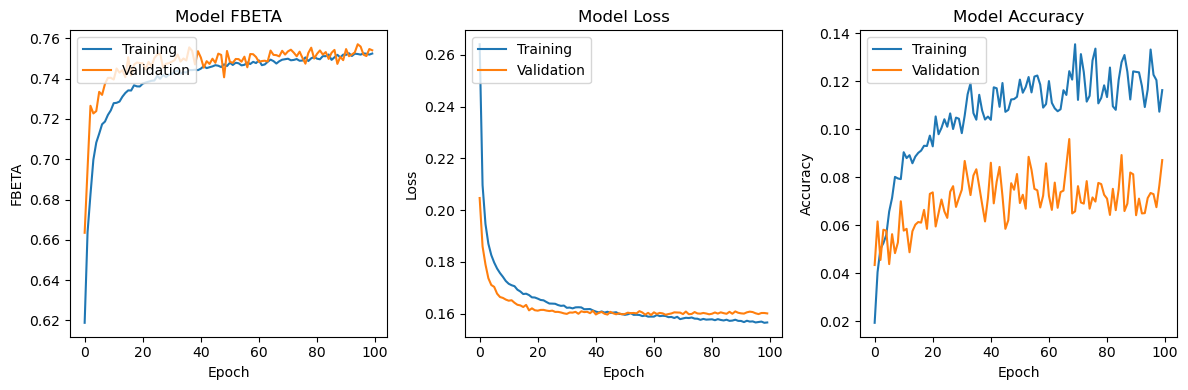

In [12]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history_PCA.history['fbeta'])
plt.plot(history_PCA.history['val_fbeta'])
plt.title('Model FBETA')
plt.ylabel('FBETA')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history_PCA.history['loss'])
plt.plot(history_PCA.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history_PCA.history['accuracy'])
plt.plot(history_PCA.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Test 02

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.decomposition import PCA

def create_PCA_model(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(34, activation='relu'))
    model.add(Dense(17, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[fbeta, 'accuracy'])
    return model

# Apply PCA to reduce the dimensionality of the training data
pca = PCA(n_components=50)

x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_train_pca = pca.fit_transform(x_train_flat)

x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_val_pca = pca.transform(x_val_flat)

x_test_flat = x_test.reshape(x_test.shape[0], -1)
x_test_pca = pca.transform(x_test_flat)


# Define the input shape for the PCA model
input_shape = (x_train_pca.shape[1],)

# Create the PCA model
model_PCA = create_PCA_model(input_shape)

# Train the model
history_PCA = model_PCA.fit(x_train_pca, y_train, validation_data=(x_val_pca, y_val), epochs=100, batch_size=128)




Epoch 1/100
253/253 [==============================] - 1s 2ms/step - loss: 0.3009 - fbeta: 0.5964 - accuracy: 0.0685 - val_loss: 0.2159 - val_fbeta: 0.6348 - val_accuracy: 0.0351
Epoch 2/100
253/253 [==============================] - 0s 2ms/step - loss: 0.2182 - fbeta: 0.6469 - accuracy: 0.0302 - val_loss: 0.1991 - val_fbeta: 0.6689 - val_accuracy: 0.0483
Epoch 3/100
253/253 [==============================] - 0s 2ms/step - loss: 0.2036 - fbeta: 0.6673 - accuracy: 0.0471 - val_loss: 0.1886 - val_fbeta: 0.6975 - val_accuracy: 0.0630
Epoch 4/100
253/253 [==============================] - 1s 2ms/step - loss: 0.1941 - fbeta: 0.6819 - accuracy: 0.0536 - val_loss: 0.1808 - val_fbeta: 0.7153 - val_accuracy: 0.0458
Epoch 5/100
253/253 [==============================] - 1s 2ms/step - loss: 0.1878 - fbeta: 0.6955 - accuracy: 0.0566 - val_loss: 0.1771 - val_fbeta: 0.7173 - val_accuracy: 0.0585
Epoch 6/100
253/253 [==============================] - 0s 2ms/step - loss: 0.1839 - fbeta: 0.7049 - accur

253/253 [==============================] - 0s 2ms/step - loss: 0.1599 - fbeta: 0.7485 - accuracy: 0.1250 - val_loss: 0.1597 - val_fbeta: 0.7459 - val_accuracy: 0.1146
Epoch 47/100
253/253 [==============================] - 1s 2ms/step - loss: 0.1599 - fbeta: 0.7474 - accuracy: 0.1259 - val_loss: 0.1601 - val_fbeta: 0.7474 - val_accuracy: 0.0640
Epoch 48/100
253/253 [==============================] - 1s 2ms/step - loss: 0.1597 - fbeta: 0.7468 - accuracy: 0.1261 - val_loss: 0.1605 - val_fbeta: 0.7495 - val_accuracy: 0.0892
Epoch 49/100
253/253 [==============================] - 0s 2ms/step - loss: 0.1596 - fbeta: 0.7477 - accuracy: 0.1138 - val_loss: 0.1604 - val_fbeta: 0.7491 - val_accuracy: 0.0756
Epoch 50/100
253/253 [==============================] - 0s 2ms/step - loss: 0.1592 - fbeta: 0.7486 - accuracy: 0.1263 - val_loss: 0.1602 - val_fbeta: 0.7524 - val_accuracy: 0.0652
Epoch 51/100
253/253 [==============================] - 0s 2ms/step - loss: 0.1589 - fbeta: 0.7485 - accuracy: 0.

253/253 [==============================] - 0s 2ms/step - loss: 0.1560 - fbeta: 0.7550 - accuracy: 0.1446 - val_loss: 0.1603 - val_fbeta: 0.7544 - val_accuracy: 0.0652
Epoch 92/100
253/253 [==============================] - 0s 2ms/step - loss: 0.1563 - fbeta: 0.7553 - accuracy: 0.1400 - val_loss: 0.1600 - val_fbeta: 0.7521 - val_accuracy: 0.1490
Epoch 93/100
253/253 [==============================] - 0s 2ms/step - loss: 0.1557 - fbeta: 0.7550 - accuracy: 0.1296 - val_loss: 0.1603 - val_fbeta: 0.7520 - val_accuracy: 0.0623
Epoch 94/100
253/253 [==============================] - 0s 2ms/step - loss: 0.1555 - fbeta: 0.7568 - accuracy: 0.1412 - val_loss: 0.1600 - val_fbeta: 0.7521 - val_accuracy: 0.0794
Epoch 95/100
253/253 [==============================] - 0s 2ms/step - loss: 0.1558 - fbeta: 0.7553 - accuracy: 0.1299 - val_loss: 0.1600 - val_fbeta: 0.7571 - val_accuracy: 0.0813
Epoch 96/100
253/253 [==============================] - 1s 2ms/step - loss: 0.1555 - fbeta: 0.7558 - accuracy: 0.

In [15]:
# Evaluate the model on the test set

test_loss, test_fbeta, test_accuracy = model_PCA.evaluate(x_test_pca, y_test)
print("Test Loss:", test_loss)
print("Test fbeta:", test_fbeta)
print("Test Accuracy:", test_accuracy)

192/192 [==============================] - 0s 773us/step - loss: 0.9001 - fbeta: 0.3820 - accuracy: 0.1395
Test Loss: 0.900075376033783
Test fbeta: 0.3820215165615082
Test Accuracy: 0.13954249024391174


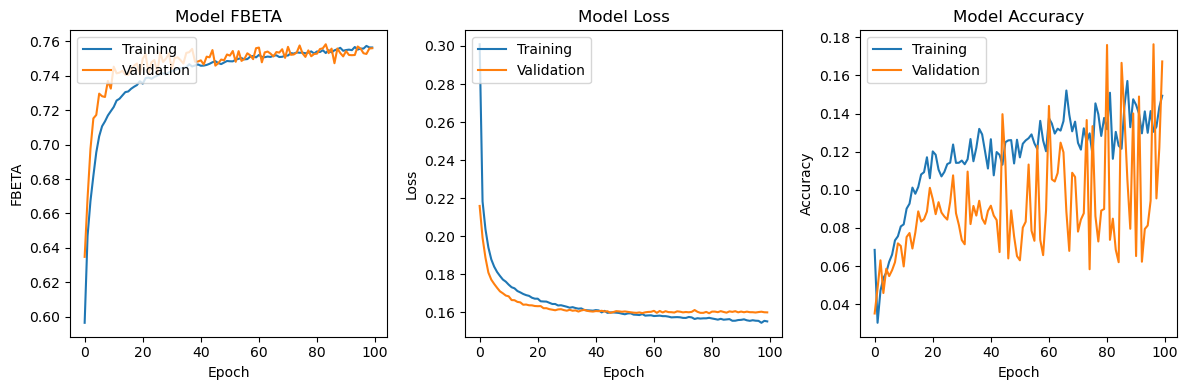

In [16]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history_PCA.history['fbeta'])
plt.plot(history_PCA.history['val_fbeta'])
plt.title('Model FBETA')
plt.ylabel('FBETA')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history_PCA.history['loss'])
plt.plot(history_PCA.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history_PCA.history['accuracy'])
plt.plot(history_PCA.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()